In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sklearn as skl
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import pandas as pd
import pickle
import h5py
import cv2
from tqdm.notebook import tqdm

import PIL
from PIL import Image
import torch
import torch.nn as nn
from torch.nn import Sequential, Conv2d, ELU, Flatten, Linear
from torch.optim import Adam

import torchvision as tv
from torchvision import transforms


from jupyterthemes import jtplot
jtplot.style(theme="gruvboxd", context="notebook", ticks=True, grid=False)
%matplotlib inline

In [2]:
DATA_DIR = "data"
TRAIN_VIDEO = os.path.join(DATA_DIR, "train.mp4")
TEST_VIDEO = os.path.join(DATA_DIR,"test.mp4")

CLEAN_DATA_DIR = "clean_data"
CLEAN_TRAIN_IMGS = os.path.join(CLEAN_DATA_DIR,"train_imgs")
CLEAN_TEST_IMGS = os.path.join(CLEAN_DATA_DIR,"test_imgs")

ASSETS_DIR = "assets"

seed = 503

In [3]:
train_meta = pd.read_csv("clean_data/train_meta.csv")
print("shape of train_meta:",train_meta.shape)

shape of train_meta: (20400, 3)


## split train and validation data

In [4]:
def meta_formatter(meta_df):
    """
    format df s.t
        [img_path, img_index, speed] -> [first_img_path,second_img_path,first_img_index,second_img_index,first_speed,second_speed]
    
    will return df with shape of (df.shape[0]-1, 6)
    """
    
    # rename the inital column names
    meta_df.rename(columns={
        "img_path":"first_img_path",
        "img_index":"first_img_index",
        "speed":"first_speed"
    }, inplace=True)
    
    # get the second image information
    second_path = meta_df["first_img_path"][1:].values
    second_index = meta_df["first_img_index"][1:].values
    second_speed = meta_df["first_speed"][1:].values
    
    # drop the last row of the input df
    meta_df.drop(meta_df.tail(1).index, inplace=True)
    
    # add second info
    meta_df["second_img_path"] = second_path
    meta_df["second_img_index"] = second_index
    meta_df["second_speed"] = second_speed
    
    # get the avg data between first and second speed
    meta_df["avg_speed"] = abs( (meta_df["first_speed"] + meta_df["second_speed"]) ) /2    
    # remove first and second speed
    #meta_df.drop(columns=["first_speed","second_speed"], inplace=True)
    
    return meta_df

In [5]:
train_meta = meta_formatter(train_meta)
train_meta

,first_img_path,first_img_index,first_speed,second_img_path,second_img_index,second_speed,avg_speed
0,clean_data\train_imgs\frame0.jpg,0,28.105569,clean_data\train_imgs\frame1.jpg,1,28.105569,28.105569
1,clean_data\train_imgs\frame1.jpg,1,28.105569,clean_data\train_imgs\frame2.jpg,2,28.106527,28.106048
2,clean_data\train_imgs\frame2.jpg,2,28.106527,clean_data\train_imgs\frame3.jpg,3,28.130404,28.118465
3,clean_data\train_imgs\frame3.jpg,3,28.130404,clean_data\train_imgs\frame4.jpg,4,28.109243,28.119823
4,clean_data\train_imgs\frame4.jpg,4,28.109243,clean_data\train_imgs\frame5.jpg,5,28.088572,28.098907
...,...,...,...,...,...,...,...
20394,clean_data\train_imgs\frame20394.jpg,20394,2.364811,clean_data\train_imgs\frame20395.jpg,20395,2.329180,2.346996
20395,clean_data\train_imgs\frame20395.jpg,20395,2.329180,clean_data\train_imgs\frame20396.jpg,20396,2.289795,2.309487
20396,clean_data\train_imgs\frame20396.jpg,20396,2.289795,clean_data\train_imgs\frame20397.jpg,20397,2.292917,2.291356
20397,clean_data\train_imgs\frame20397.jpg,20397,2.292917,clean_data\train_imgs\frame20398.jpg,20398,2.260600,2.276759


In [6]:
train_df, val_df = train_test_split(train_meta, train_size= 0.75, random_state=seed)

train_df.reset_index(drop=True,inplace=True)
val_df.reset_index(drop=True,inplace=True)
print(train_df.shape, val_df.shape)
train_df.head()

(15299, 7) (5100, 7)


,first_img_path,first_img_index,first_speed,second_img_path,second_img_index,second_speed,avg_speed
0,clean_data\train_imgs\frame7755.jpg,7755,24.653383,clean_data\train_imgs\frame7756.jpg,7756,24.661064,24.657224
1,clean_data\train_imgs\frame15776.jpg,15776,0.485482,clean_data\train_imgs\frame15777.jpg,15777,0.487062,0.486272
2,clean_data\train_imgs\frame19153.jpg,19153,9.724499,clean_data\train_imgs\frame19154.jpg,19154,9.680809,9.702654
3,clean_data\train_imgs\frame4094.jpg,4094,21.229045,clean_data\train_imgs\frame4095.jpg,4095,21.215251,21.222148
4,clean_data\train_imgs\frame16599.jpg,16599,2.258273,clean_data\train_imgs\frame16600.jpg,16600,2.271131,2.264702


### Plot train and validation distribution within the train_meta

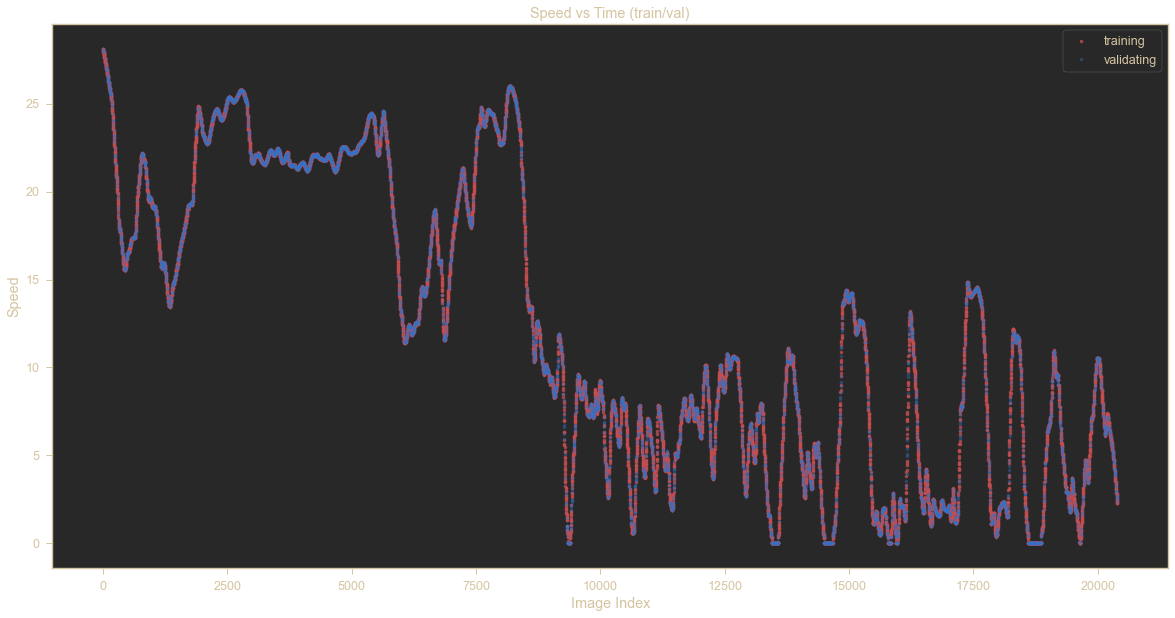

***************

training set shape:  (15299, 7)
validation set shape:  (5100, 7)


In [7]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(train_df.sort_values("first_img_index")[["first_img_index"]], train_df.sort_values("first_img_index")[["first_speed"]],"r.",alpha=0.8)
plt.plot(val_df.sort_values("first_img_index")[["first_img_index"]], val_df.sort_values("first_img_index")[["first_speed"]],"b.", alpha=0.4)
plt.xlabel("Image Index")
plt.ylabel("Speed")
plt.title("Speed vs Time (train/val)")
plt.legend(["training","validating"], loc="upper right")
plt.show()
plt.close()
print("***************\n")
print("training set shape: ",train_df.shape)
print("validation set shape: ",val_df.shape)

In [8]:
def brightness_augmentation(image, factor):
    """
    augements brigtness of the image by multiplying the saturation by a uniform random variable
    return: image with brightness augmentation
    """
    hsv = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    hsv = np.array(hsv, dtype=np.float64)
    hsv[:,:,2] = hsv[:,:,2] * factor
    rgb = cv2.cvtColor(np.array(hsv,dtype=np.uint8), cv2.COLOR_HSV2RGB)
    return rgb
    
    

original image shape: (480, 640, 3)


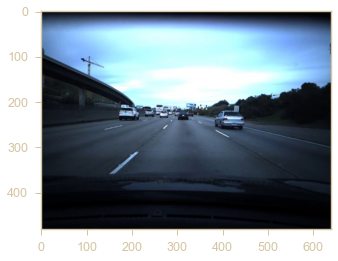

bright_factor: 1.6852132980063472
brightned image


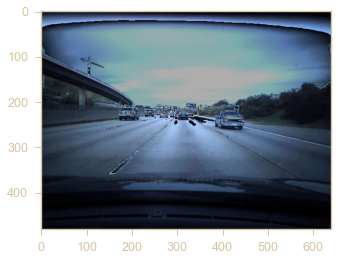

In [9]:
img=mpimg.imread(train_meta['first_img_path'][60])
print('original image shape:', img.shape)
plt.imshow(img)
plt.show()
plt.close()

bright_factor = 0.7 + np.random.uniform()
print('bright_factor:', bright_factor)
print('brightned image')
img=mpimg.imread(train_meta['first_img_path'][60])
plt.imshow(brightness_augmentation(img, bright_factor))
plt.show()
plt.close()

In [10]:
def opticalFlowDense(curr_img, next_img):
    """
    input: curr_img, next_img (RGB images)
    
    Calculates optical flow magnitude and angle and place it into HSV image
    
    - Set the saturation to the saturation value of next_img
    - Set the hue to the angles returned from computing the flow params
    - Set the value to the magnitude returned from computing the flow params
    - Convert from HSV to RGB and return RGB image with same size as the original image
    """
    gray_curr = cv2.cvtColor(curr_img, cv2.COLOR_RGB2GRAY)
    gray_next = cv2.cvtColor(next_img, cv2.COLOR_RGB2GRAY)
    
    hsv = np.zeros(shape=(66, 220, 3))
    #set saturation
    hsv[:,:,1] = cv2.cvtColor(next_img, cv2.COLOR_RGB2HSV)[:,:,1]

    # FlowParams
    flow_mat = None
    image_scale = 0.5
    nb_images = 1
    win_size = 15
    nb_iterations = 2
    deg_expansion = 5
    STD = 1.3
    extra = 0
    
    # obtain dense optical flow params
    flow = cv2.calcOpticalFlowFarneback(gray_curr, gray_next,
                                       flow_mat,
                                       image_scale,
                                       nb_images,
                                       win_size,
                                       nb_iterations,
                                       deg_expansion,
                                       STD,
                                       extra)
    # convert from cartesian to polar
    mag, ang = cv2.cartToPolar(flow[...,0],flow[...,1])
    
    #hue corresponds to direction
    hsv[:,:,0] = ang*(180 / np.pi / 2)
    
    # value corresponds to mag
    hsv[:,:,2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    
    # convert hsv to float32
    hsv = np.asarray(hsv, dtype=np.float32)
    rgb_flow = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    
    return rgb_flow

    

In [11]:
def preprocess_image(image):
    """
    preprocesses the image: trim top and bottom and resize the image to (220,66,3)
    
    input: image (480,640,3) rgb 
    output: image( 220,66,3) rgb
    
    1. crop out black spots
    2. resize to 220,66,3 if not done from perspective transform
    """
    image_cropped = image[35:375, :] #v1 for data
    image = cv2.resize(image_cropped,(220,66), interpolation=cv2.INTER_AREA)
    return image

original image shape: (480, 640, 3)


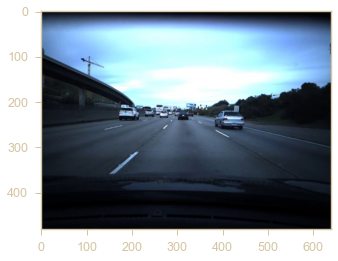

post prosessed image: (66, 220, 3)


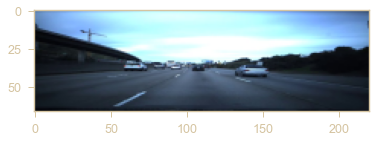

In [12]:
mg=mpimg.imread(train_meta['first_img_path'][10])
print('original image shape:', img.shape)
plt.imshow(img)
plt.show()
plt.close()

post_img = preprocess_image(img)
print('post prosessed image:', post_img.shape)
plt.imshow(post_img)
plt.show()
plt.close()

In [13]:
def preprocess_img_valid_from_path(img_path,speed):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = preprocess_image(img)
    return img, speed
def preprocess_img_from_path(img_path, speed, bright_factor):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = brightness_augmentation(img,bright_factor)
    img = preprocess_image(img)
    return img, speed

In [14]:
def generate_training_data(data,input_size,batch_size = 8):
    image_batch = np.zeros((batch_size, 66,220,3))
    label_batch = np.zeros((batch_size))
    
    while True:
        for i in range(batch_size):
            # get a random index 
            idx = np.random.randint(len(data)-1)
            brighting_factor = 0.2 + np.random.uniform()
            
            row1 = data.iloc[[idx]]
            row2 = data.iloc[[idx + 1]]
            
            # preprocess and get speed data
            x1,y1 = preprocess_img_from_path(row1["img_path"].values[0], row1["speed"].values[0], brighting_factor)
            x2,y2 = preprocess_img_from_path(row2["img_path"].values[0], row2["speed"].values[0], brighting_factor)
            
            # get the flow from two frames
            flow = opticalFlowDense(x1,x2)
            
            # get the avg speed between two frames
            y = np.mean([y1,y2])
            
            image_batch[i] = flow
            label_batch[i] = y
            
        yield skl.utils.shuffle(image_batch, label_batch)

In [15]:
def generate_val_data(data):
    while True:
        for i in range(len(data)-1):
            row1 = data.iloc[[i]]
            row2 = data.iloc[[i+1]]
            
            x1,y1 = preprocess_img_valid_from_path(row1["img_path"].values[0],row1["speed"].values[0])
            x2,y2 = preprocess_img_valid_from_path(row2["img_path"].values[0],row2["speed"].values[0])
            
            flow = opticalFlowDense(x1,x2)
            
            # reshape so that it matches the shape as training
            flow = flow.reshape(1, flow,shape[0], flow.shape[1], flow.shape[2])
            
            y = np.mean([y1,y2])
            
            yield flow, np.array([[y]])
            

In [16]:
class SpeedChallengeDataSet(torch.utils.data.Dataset):
    # NOTE: This custom dataset works with clean_data directory stuff only
    def __init__(self, csv_file, root_dir, transforms=None ):
        
        pair_img_data = csv_file # if csv_file == pandas df
        if isinstance(csv_file, str ):
            pair_img_data = pd.read_csv(csv_file)
        if pair_img_data.shape[1] !=6:
            pair_img_deta = meta_formatter(pair_img_data)
            
        self.pair_img_data = pair_img_data
        self.root_dir = root_dir # i dont think its needed unless dataloader utilizes
        self.transforms = transforms
        
    def __len__(self):
        return len(self.pair_img_data)
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        # i think i need to do the opticalFlowDense() here
        
        first_img_path = self.pair_img_data.loc[idx,"first_img_path"]
        second_img_path = self.pair_img_data.loc[idx, "second_img_path"]
        
        first_img = mpimg.imread(first_img_path)
        second_img = mpimg.imread(second_img_path)
        
        first_speed = self.pair_img_data.loc[idx,"first_speed"]
        second_speed = self.pair_img_data.loc[idx,"second_speed"]
        
        optical_flow = opticalFlowDense(preprocess_image(first_img),preprocess_image(second_img))
        avg_speed = np.mean([first_speed, second_speed])
        
        sample = {"first_img":first_img,
                  "second_img":second_img,
                  "first_speed":first_speed,
                  "second_speed":second_speed,
                  "flow":optical_flow,
                  "avg_speed":avg_speed}
        if self.transforms:
            sample = self.transforms(sample)
            
        return sample

    
class ToTensor(object):
    def __call__(self, sample):
        f_img, s_img, flow = sample["first_img"], sample["second_img"], sample["flow"]
        f_speed, s_speed, avg_speed = sample["first_speed"], sample["second_speed"],sample["avg_speed"]
        
        # change order of channels
        # H x W x C => C x H x W
        f_img = f_img.transpose((2,0,1))
        s_img = s_img.transpose((2,0,1))
        flow = flow.transpose((2,0,1))
        
        return {"first_img" : torch.from_numpy(f_img),
               "second_img" : torch.from_numpy(s_img),
                "first_speed" : f_speed,
                "second_speed" : s_speed,
                "flow" : torch.from_numpy(flow),
                "avg_speed" : avg_speed
               }

In [27]:
isinstance(train_df, str)

False

In [29]:
tensor_train_df = SpeedChallengeDataSet(csv_file=train_df, root_dir="clean_data/train_imgs/", transforms=transforms.Compose([ToTensor()]))
tensor_val_df = SpeedChallengeDataSet(csv_file=val_df, root_dir="clean_data/train_imgs/", transforms=transforms.Compose([ToTensor()]))

train_data_loader = torch.utils.data.DataLoader(tensor_train_df, batch_size=8, )
val_data_loader = torch.utils.data.DataLoader(tensor_val_df, batch_size=1)

C:\Users\yahoy\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\pandas\core\frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\yahoy\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\yahoy\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [30]:
tmp_dataset = SpeedChallengeDataSet(csv_file="clean_data/train_meta.csv", root_dir="clean_data/train_imgs/", transforms=transforms.Compose([ToTensor()]))

for i in range(len(tmp_dataset))[:10]:
    sample = tmp_dataset[i]
    print(i, sample["first_img"].size(), sample["second_img"].size(), sample["first_speed"], sample["second_speed"], sample["flow"].size())
    


0 torch.Size([3, 480, 640]) torch.Size([3, 480, 640]) 28.105569 28.105569 torch.Size([3, 66, 220])
1 torch.Size([3, 480, 640]) torch.Size([3, 480, 640]) 28.105569 28.106527000000003 torch.Size([3, 66, 220])
2 torch.Size([3, 480, 640]) torch.Size([3, 480, 640]) 28.106527000000003 28.130404 torch.Size([3, 66, 220])
3 torch.Size([3, 480, 640]) torch.Size([3, 480, 640]) 28.130404 28.109243 torch.Size([3, 66, 220])
4 torch.Size([3, 480, 640]) torch.Size([3, 480, 640]) 28.109243 28.088572 torch.Size([3, 66, 220])
5 torch.Size([3, 480, 640]) torch.Size([3, 480, 640]) 28.088572 28.034211 torch.Size([3, 66, 220])
6 torch.Size([3, 480, 640]) torch.Size([3, 480, 640]) 28.034211 28.018491 torch.Size([3, 66, 220])
7 torch.Size([3, 480, 640]) torch.Size([3, 480, 640]) 28.018491 27.986624 torch.Size([3, 66, 220])
8 torch.Size([3, 480, 640]) torch.Size([3, 480, 640]) 27.986624 28.016352 torch.Size([3, 66, 220])
9 torch.Size([3, 480, 640]) torch.Size([3, 480, 640]) 28.016352 27.981986 torch.Size([3, 66

C:\Users\yahoy\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:58: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)


In [140]:
data_loader = torch.utils.data.DataLoader(tmp_dataset, batch_size=8, shuffle=True)#, num_workers=8)
for i_batch, batch_samples in enumerate(data_loader):
    print(i_batch, batch_samples["flow"].size(), batch_samples["avg_speed"] )
    if i_batch == 10:
        break

0 torch.Size([8, 3, 66, 220]) tensor([ 4.6496,  4.2042, 25.4921, 25.7572, 16.2885, 12.4023,  9.3196,  1.9667],
       dtype=torch.float64)
1 torch.Size([8, 3, 66, 220]) tensor([22.3617, 12.5524,  5.5936,  1.9343, 14.3881, 12.3879,  2.1697, 22.1315],
       dtype=torch.float64)
2 torch.Size([8, 3, 66, 220]) tensor([ 9.1486, 10.1575,  9.9786, 18.6310, 11.7804, 24.1236,  7.6572,  9.0854],
       dtype=torch.float64)
3 torch.Size([8, 3, 66, 220]) tensor([11.2248,  2.3288, 10.2174,  7.0085, 19.3164,  9.0847, 15.5271, 19.1320],
       dtype=torch.float64)
4 torch.Size([8, 3, 66, 220]) tensor([ 2.4872, 16.2070, 12.7463, 24.2941, 11.7922, 18.0226, 23.2850, 22.7465],
       dtype=torch.float64)
5 torch.Size([8, 3, 66, 220]) tensor([18.5855, 12.1820,  7.8542,  7.5468,  9.2106, 21.4858, 17.3571,  6.2351],
       dtype=torch.float64)
6 torch.Size([8, 3, 66, 220]) tensor([ 1.9561,  7.2514, 14.2273,  8.9641,  0.0000,  7.7592, 22.1447,  0.6589],
       dtype=torch.float64)
7 torch.Size([8, 3, 66, 220

In [ ]:
batch_size = 8
num_epochs = 25
steps_per_epoch = 400
fps = 20
input_shape = (3,66,220)

def speedchallenge_model():
    model = nn.Sequential()
    
    
    

In [35]:
class SpeedChallengeModel(nn.Module):
    def __init__(self):
        super(SpeedChallengeModel, self).__init__()
        self.conv2d = Conv2d()
    def forward(self, x):
        

array([[[12,  2, 69, ..., 52, 64, 35],
        [56, 96, 85, ..., 24, 47, 89],
        [13, 78, 89, ..., 48, 92, 50],
        ...,
        [73, 34, 27, ..., 89, 35,  7],
        [22, 96, 92, ...,  3, 97, 59],
        [51, 38, 10, ..., 68, 24, 22]],

       [[63, 94, 99, ..., 87, 97, 25],
        [44,  4, 67, ..., 52, 32, 25],
        [83, 56, 63, ..., 97, 21, 88],
        ...,
        [24, 95, 61, ..., 30, 41, 41],
        [54, 12, 11, ..., 66,  2, 18],
        [85, 65, 81, ...,  2, 10, 97]],

       [[58, 79, 79, ..., 21, 75, 30],
        [24, 84, 45, ..., 33, 77, 97],
        [17, 33, 69, ..., 36, 76, 38],
        ...,
        [ 1, 97, 60, ..., 93, 82,  1],
        [37, 35, 41, ..., 86, 88, 49],
        [79, 76, 20, ..., 58, 87, 98]]])

In [42]:
"""
image_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}



# Load the Data

# Set train and valid directory paths
train_directory = 'train'
valid_directory = 'test'

# Batch size
bs = 32

# Number of classes
num_classes = 10

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid']),
    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}

# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
valid_data_size = len(data['valid'])
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
train_data = DataLoader(data['train'], batch_size=bs, shuffle=True)
valid_data = DataLoader(data['valid'], batch_size=bs, shuffle=True)
test_data = DataLoader(data['test'], batch_size=bs, shuffle=True)

# Print the train, validation and test set data sizes
train_data_size, valid_data_size, test_data_size



# Define Optimizer and Loss Function
loss_func = nn.NLLLoss()
optimizer = optim.Adam(resnet50.parameters())


""";

In [43]:
"""
for epoch in range(epochs):
    epoch_start = time.time()
    print("Epoch: {}/{}".format(epoch+1, epochs))
     
    # Set to training mode
    model.train()
     
    # Loss and Accuracy within the epoch
    train_loss = 0.0
    train_acc = 0.0
     
    valid_loss = 0.0
    valid_acc = 0.0
 
    for i, (inputs, labels) in enumerate(train_data_loader):
 
        inputs = inputs.to(device)
        labels = labels.to(device)
         
        # Clean existing gradients
        optimizer.zero_grad()
         
        # Forward pass - compute outputs on input data using the model
        outputs = model(inputs)
         
        # Compute loss
        loss = loss_criterion(outputs, labels)
         
        # Backpropagate the gradients
        loss.backward()
         
        # Update the parameters
        optimizer.step()
         
        # Compute the total loss for the batch and add it to train_loss
        train_loss += loss.item() * inputs.size(0)
         
        # Compute the accuracy
        ret, predictions = torch.max(outputs.data, 1)
        correct_counts = predictions.eq(labels.data.view_as(predictions))
         
        # Convert correct_counts to float and then compute the mean
        acc = torch.mean(correct_counts.type(torch.FloatTensor))
         
        # Compute total accuracy in the whole batch and add to train_acc
        train_acc += acc.item() * inputs.size(0)
         
        print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))
        
        
        
        
        
        # Validation - No gradient tracking needed
with torch.no_grad():
 
    # Set to evaluation mode
    model.eval()
 
    # Validation loop
    for j, (inputs, labels) in enumerate(valid_data_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
 
        # Forward pass - compute outputs on input data using the model
        outputs = model(inputs)
 
        # Compute loss
        loss = loss_criterion(outputs, labels)
 
        # Compute the total loss for the batch and add it to valid_loss
        valid_loss += loss.item() * inputs.size(0)
 
        # Calculate validation accuracy
        ret, predictions = torch.max(outputs.data, 1)
        correct_counts = predictions.eq(labels.data.view_as(predictions))
 
        # Convert correct_counts to float and then compute the mean
        acc = torch.mean(correct_counts.type(torch.FloatTensor))
 
        # Compute total accuracy in the whole batch and add to valid_acc
        valid_acc += acc.item() * inputs.size(0)
 
        print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
     
# Find average training loss and training accuracy
avg_train_loss = train_loss/train_data_size
avg_train_acc = train_acc/float(train_data_size)
 
# Find average training loss and training accuracy
avg_valid_loss = valid_loss/valid_data_size
avg_valid_acc = valid_acc/float(valid_data_size)
 
history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
         
epoch_end = time.time()
 
print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))

        
""";

In [44]:
"""
resnet50 = resnet50.to('cuda:0')
"""

torch.cuda.current_device()

0

In [45]:
torch.cuda.get_device_name(0)

'GeForce GTX 1050'

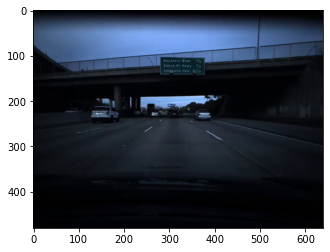

In [57]:
img = mpimg.imread("clean_data/train_imgs/frame0.jpg")
plt.imshow(img)

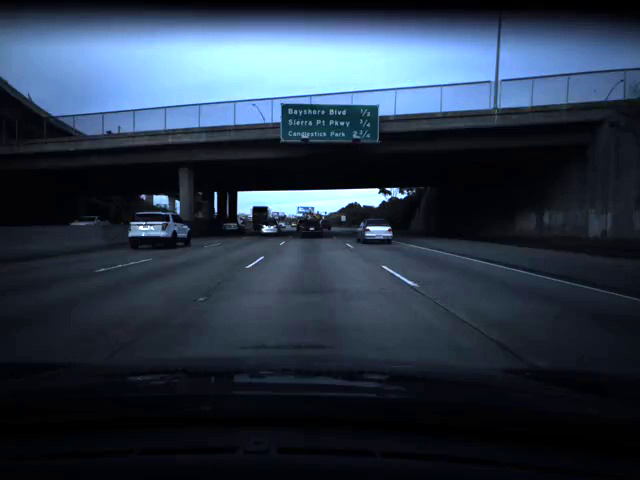

In [68]:
torchvision.transforms.functional.adjust_brightness(Image.fromarray(img),0.7+np.random.uniform())